# Multi-Layer Perceptron Regression

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import r2_score

import sys
sys.path.append('/home/jshe/prop-pred/src/data')
from data_utils.load_immuno import *

import torch
from torch.utils.data import DataLoader, TensorDataset
from models import MLPRegressor, RMLPRegressor, PMLPRegressor, RPMLPRegressor

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [5]:
datadir = '../../data/regress_immuno'
data = to_namedtuple(to_tensor(load_immuno(datadir, x_type='embeddings'), device))

In [6]:
train_X = data.train.x
validation_X = data.validation.x
test_X = data.test.x

In [20]:
train_X = torch.concat((data.train.x, data.train.y), dim=1)
validation_X = torch.concat((data.validation.x, data.validation.y), dim=1)
test_X = torch.concat((data.test.x, data.test.y), dim=1)

In [22]:
train_Var = data.train.y_std ** 2
validation_Var = data.validation.y_std ** 2

In [23]:
train_Y = data.train.y
validation_Y = data.validation.y
test_Y = data.test.y

In [24]:
#dataset = GaussianSamplingDataset(train_X, train_Y, train_Var)
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

## MLP Model

In [25]:
model = RMLPRegressor(
    in_features=train_X.shape[1], out_features=train_Y.shape[1], 
    depth=2, width=512, dropout=0.4
).to(device)

## Train

 11%|█████▉                                              | 117/1024 [00:38<04:56,  3.06it/s]


Val.: 0.9916
Test: 0.9904
[0.99315374 0.99170521 0.98998313 0.98554873 0.9891638  0.99415236
 0.989052  ]


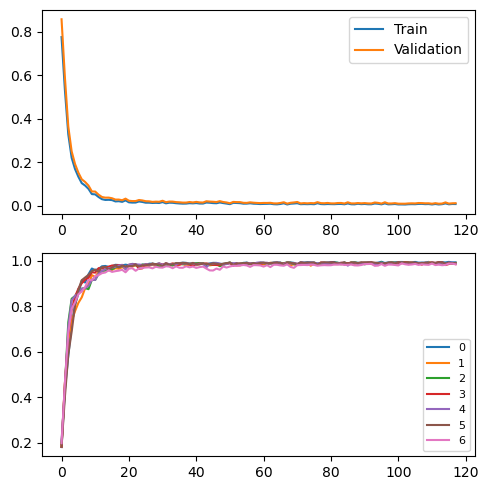

In [26]:
validation_score = model.fit(
    train_X=train_X, train_Y=train_Y, train_Var=train_Var, 
    validation_X=validation_X, validation_Y=validation_Y, validation_Var=validation_Var, 
    #dataloader=dataloader, 
    lr=0.0001, epochs=1024, patience=0.002, 
    early_stopping=True, plot=True, show_progress=True
)
test_score = model.score(test_X, test_Y)

print(f'Val.: {validation_score:.4f}')
print(f'Test: {test_score:.4f}')
print(model.score(test_X, test_Y, multioutput='raw_values'))

## Visualization

In [9]:
x, y_true = test_X, test_Y

In [10]:
y_pred = model(x).detach()

In [11]:
scores = r2_score(y_true.cpu(), y_pred.cpu(), multioutput='raw_values')
print(scores)

[ 0.09506017 -0.03040584  0.08210247 -0.02150714  0.04831437 -0.02380949
  0.10607562]


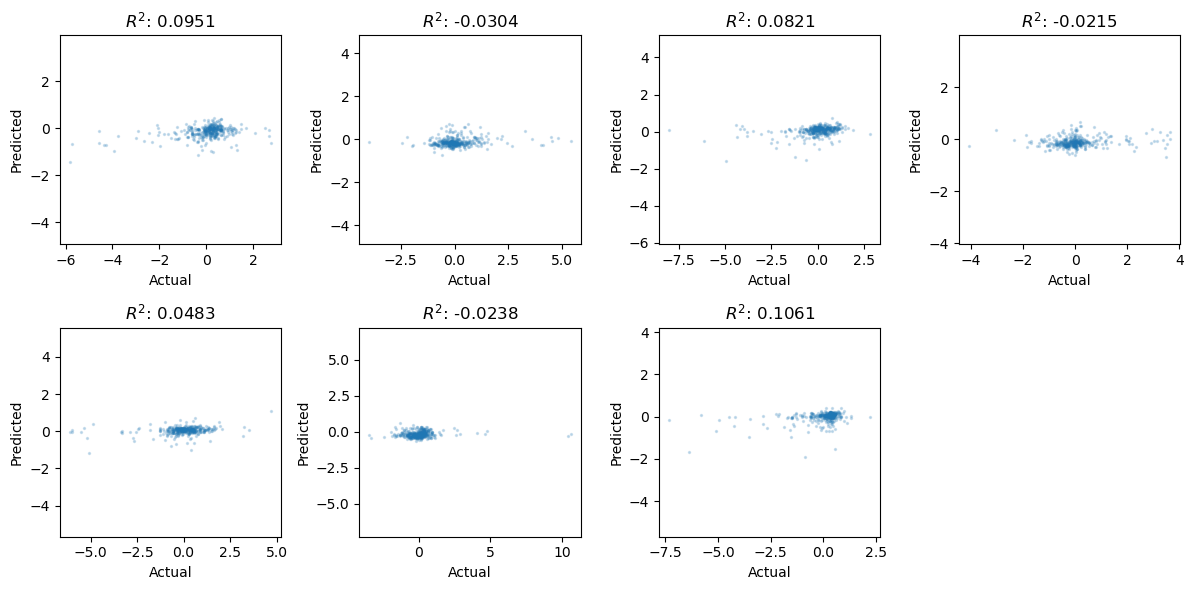

In [12]:
n_rows = n_cols = int((y_pred.shape[1]) ** 0.5)
while (n_rows * n_cols) < y_pred.shape[1]: n_cols += 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
axs = [axs] if y_pred.shape[1] == 1 else axs.flatten()

for i in range(y_pred.shape[1]):

    ax = axs[i]

    ax.scatter(y_true[:, i].cpu(), y_pred[:, i].cpu(), s=2, alpha=0.2)
    #ax.errorbar(
    #    y_true[:, i].cpu(), y_pred[:, i].cpu(), y_pred_std[:, i].cpu(), 
    #    fmt='.', markersize=2, alpha=0.2
    #)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'$R^2$: {scores[i]:.4f}')
    ax.set_aspect('equal', adjustable='datalim')

axs[-1].axis('off')

plt.tight_layout()